In [1]:
# -*- coding: utf-8 -*-
import sys; print('Python %s on %s' % (sys.version, sys.platform))
import os
import time
import json
from glob import glob, iglob
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np; print('numpy', np.__version__)
import pandas as pd; print('pandas', pd.__version__)
import cv2; print('opencv2', cv2.__version__)
import sklearn; print('sklearn', sklearn.__version__)
import tensorflow as tf; print('tensorflow', tf.__version__)
import tensorflow.keras as keras; print('keras', keras.__version__)

import settings
import helper
import visual

Python 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]] on linux
numpy 1.16.4
pandas 0.24.2
opencv2 4.1.0
sklearn 0.21.2
tensorflow 1.14.0
keras 2.2.4-tf


# 1. Load Meta File and Annotation

In [2]:
df_meta_train = pd.read_csv(filepath_or_buffer=settings.PREPROCESS_TRAIN_META_FILE, index_col=['seriesuid'])
df_meta_train.index = df_meta_train.index.astype('str')
df_meta_test = pd.read_csv(filepath_or_buffer=settings.PREPROCESS_TEST_META_FILE, index_col=['seriesuid'])
df_meta_test.index = df_meta_test.index.astype('str')

print('meta_train:', df_meta_train.shape, '\n', 'meta_test:', df_meta_test.shape)

meta_train: (1470, 11) 
 meta_test: (145, 11)


In [3]:
df_annotation = pd.read_csv(filepath_or_buffer=settings.PREPROCESS_ANNOTATION_FILE, index_col=['seriesuid'])
df_annotation.index = df_annotation.index.astype('str')
df_annotation['label'] = df_annotation['label'].astype('int')
print('annotation:', df_annotation.shape, 'distinct lung:', len(set(df_annotation.index)))

annotation: (12218, 16) distinct lung: 1436


In [4]:
df_annotation.sample(10)

,width,height,slice,vcoordX,vcoordY,vcoordZ,diameterX,diameterY,diameterZ,originX,originY,originZ,spacingX,spacingY,spacingZ,label
seriesuid,,,,,,,,,,,,,,,,
671750,320,320,270,74.375000,204.375000,90.0,5.625000,5.625000,5.0,-170.687500,-280.687500,-550.400024,0.625000,0.625000,5.0,1
369786,388,388,387,242.500000,215.976562,270.0,6.820312,5.304688,1.0,-185.852005,-53.700001,-520.080017,0.757812,0.757812,1.0,31
528297,391,391,342,237.501953,159.607422,166.0,12.982422,12.982422,1.0,-202.537994,-77.900002,-364.190002,0.763672,0.763672,1.0,31
670219,371,371,320,286.583008,104.343750,125.0,15.941406,13.767578,5.0,-180.053635,-185.137695,-111.142090,0.724609,0.724609,5.0,5
655698,350,350,330,72.802734,129.541016,130.0,5.468750,5.468750,5.0,-173.658203,-299.658203,-544.000000,0.683594,0.683594,5.0,1
676184,350,350,260,175.683594,166.455078,163.0,8.886719,8.203125,10.0,-195.720764,-174.658203,-355.767700,0.683594,0.683594,5.0,32
697559,350,350,325,160.302734,78.613281,170.0,12.304688,28.027344,15.0,-173.931931,-174.658203,-356.862183,0.683594,0.683594,5.0,5
399492,283,283,280,144.816406,126.023438,182.0,7.185547,4.974609,10.0,-139.771027,-141.223633,1267.730957,0.552734,0.552734,5.0,32
689520,343,343,255,262.274414,163.460938,92.0,24.117188,14.068359,10.0,-151.165039,-311.165039,-751.000000,0.669922,0.669922,5.0,5


annotation 结节[1] (3264, 16)
box_w: [204.39453125 316.38865483]
box_h: [124.68501955 235.83984375]


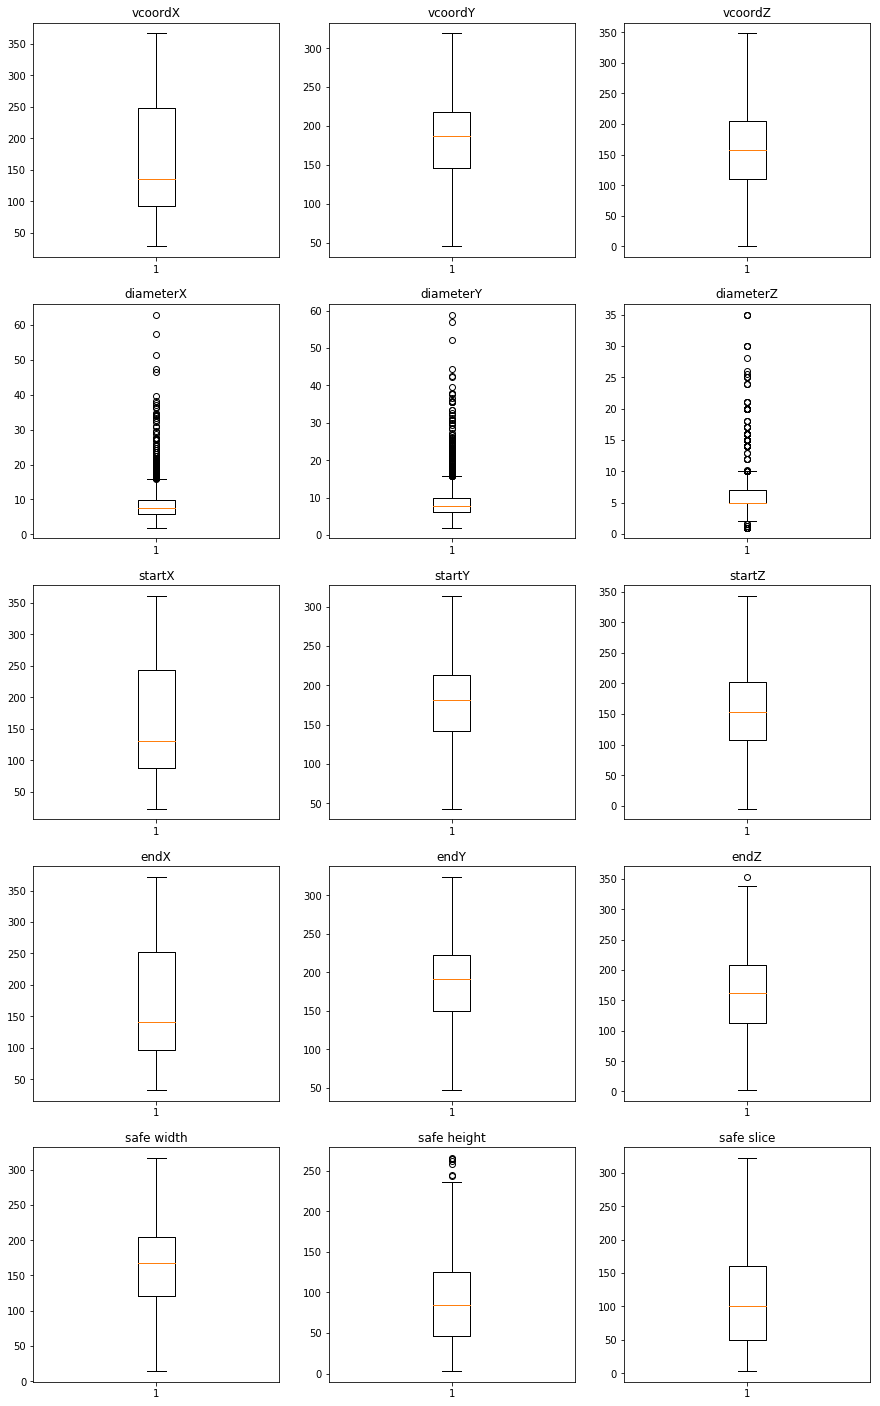

In [5]:
visual.plot_annotation(df_annotation[df_annotation['label']==1].copy(), title='annotation 结节[1]')

annotation 索条[5] (3613, 16)
box_w: [206.43697935 329.35300022]
box_h: [157.01367188 280.04882812]


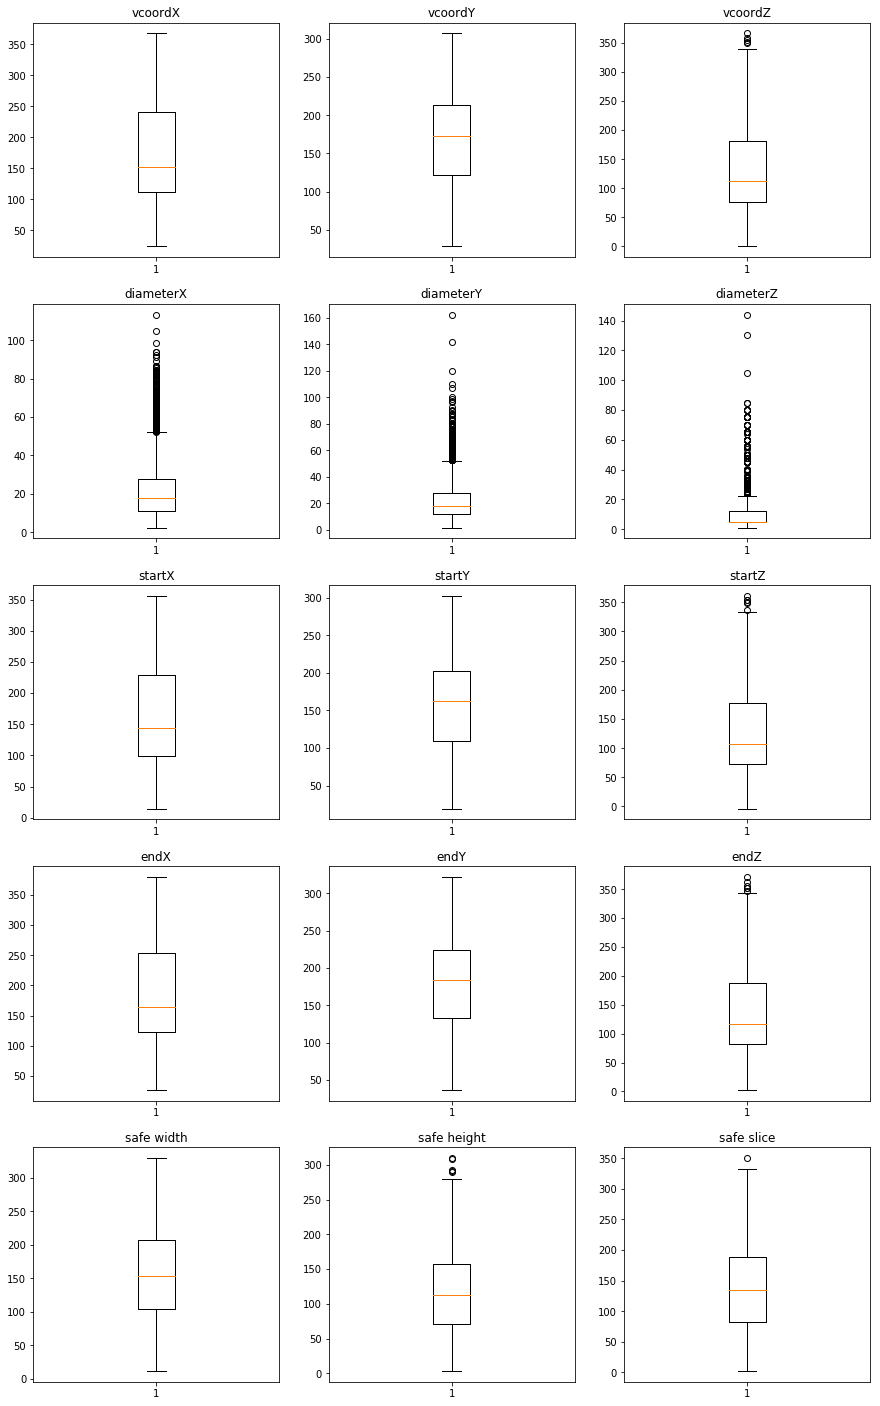

In [6]:
visual.plot_annotation(df_annotation[df_annotation['label']==5].copy(), title='annotation 索条[5]')

annotation 动脉硬化或钙化[31] (4201, 16)
box_w: [ 74.578125 134.578125]
box_h: [ 88.18359375 171.58203125]


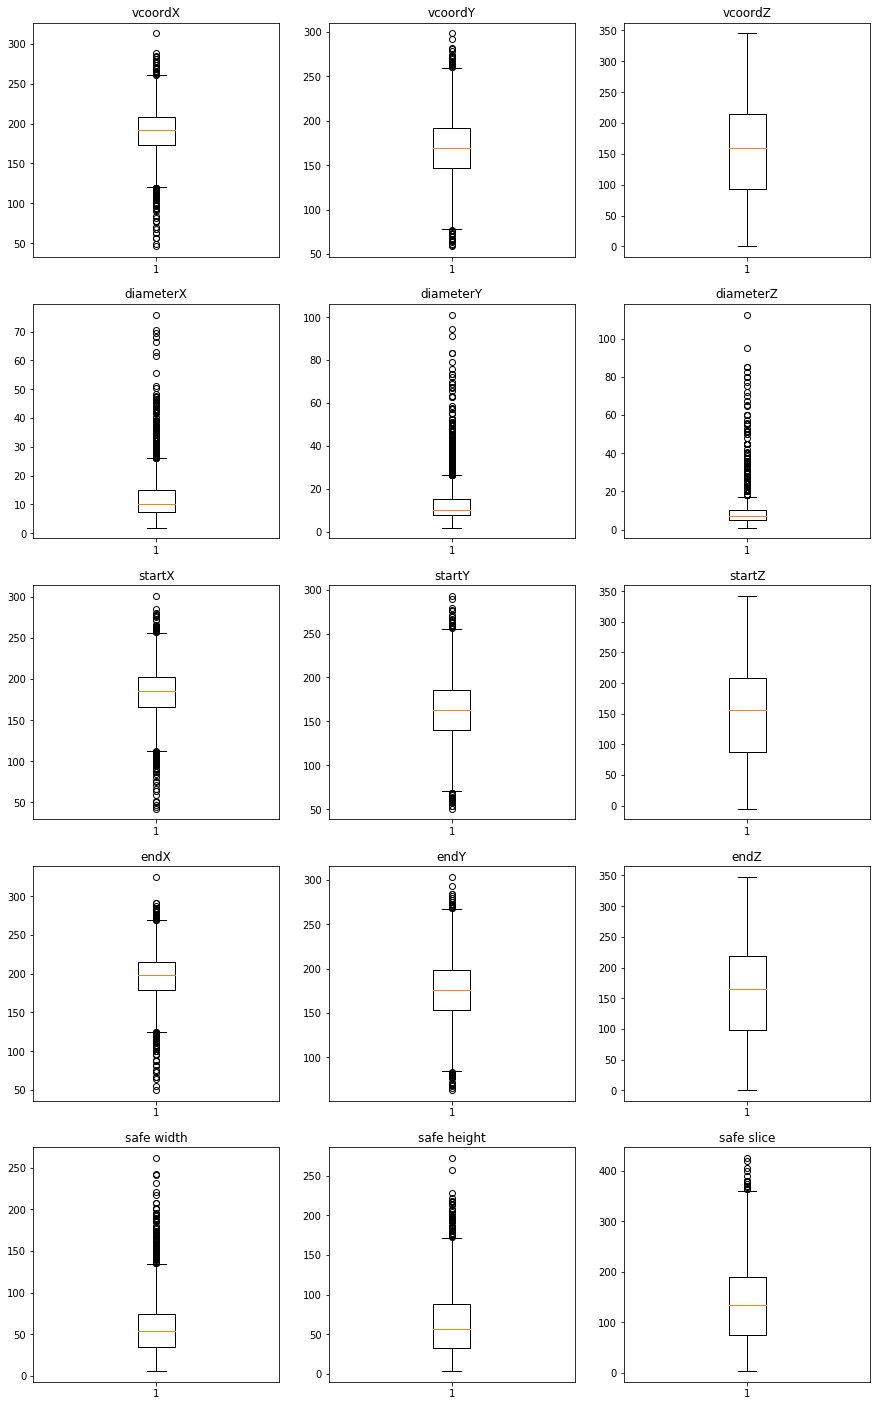

In [7]:
visual.plot_annotation(df_annotation[df_annotation['label']==31].copy(), title='annotation 动脉硬化或钙化[31]')

annotation 淋巴结钙化[32] (1140, 16)
box_w: [ 81.34765625 148.51757812]
box_h: [ 60.42909274 116.16981137]


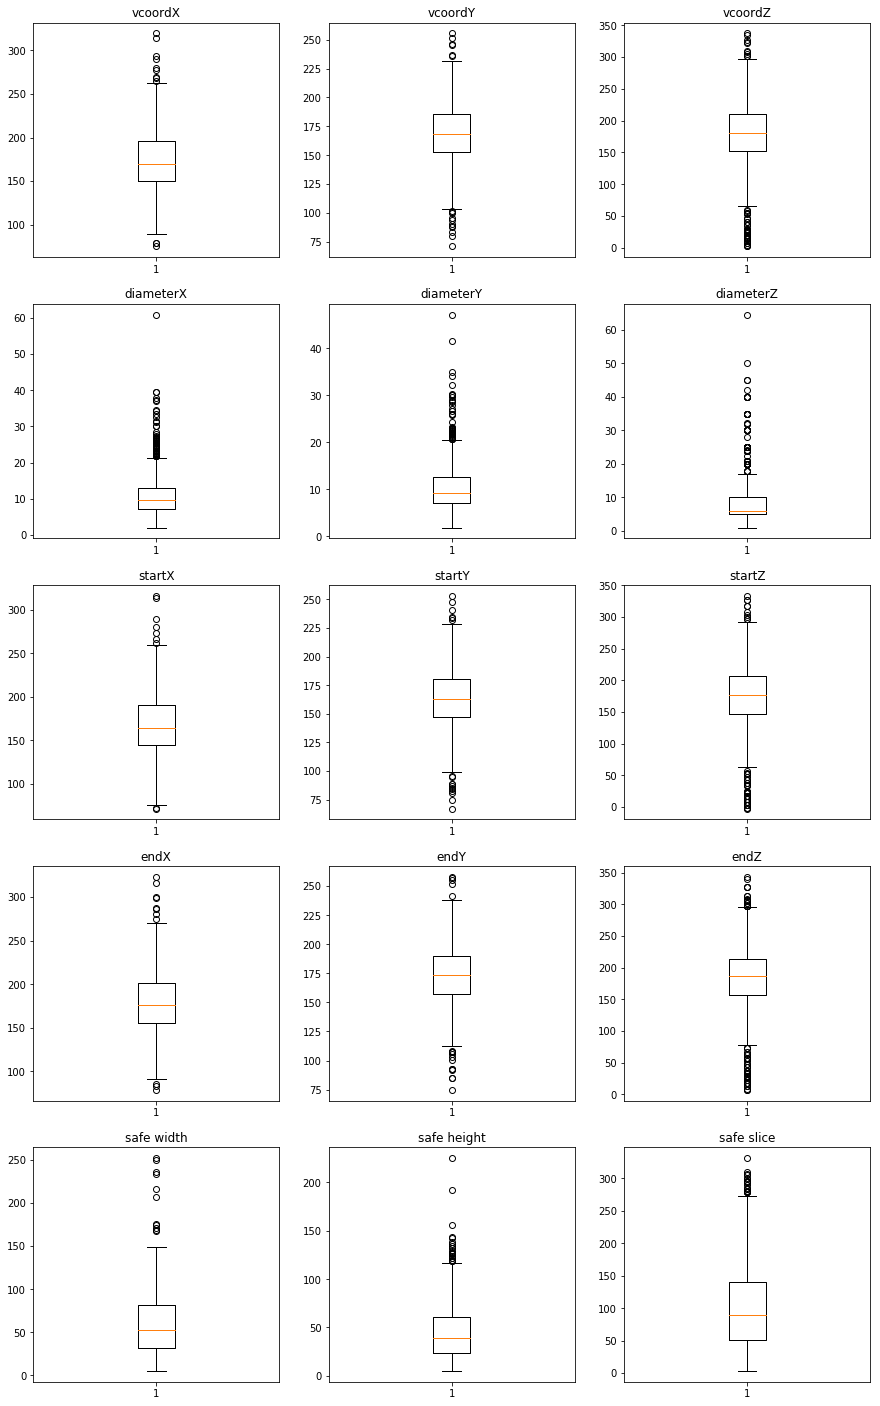

In [8]:
visual.plot_annotation(df_annotation[df_annotation['label']==32].copy(), title='annotation 淋巴结钙化[32]')

# 2. Generate Center Coords by Sliding Window

In [9]:
lungs = list(set(df_meta_test.index))
print('distinct lungs in testset:', len(lungs))

distinct lungs in testset: 145


In [10]:
list_test_tasks = []
size = settings.CUBE_SIZE
step = settings.SLIDING_WINDOW_STEP
start = [ size//2, size//2, size//2 ] # z,y,x

for uid in tqdm(lungs):
    meta = df_meta_test.loc[uid] # slice
    
    for z in range(start[0], int(meta.slice), step):
        for y in range(start[1], int(meta.height), step):
            for x in range(start[2], int(meta.width), step):
                task = {}
                task['seriesuid'] = uid
                task['vcoordX'] = x
                task['vcoordY'] = y
                task['vcoordZ'] = z
                
                # print(task)
                list_test_tasks.append(task)

100%|██████████| 145/145 [00:13<00:00, 10.78it/s]


In [11]:
df_test_tasks = pd.DataFrame(list_test_tasks, columns=['seriesuid','vcoordX','vcoordY','vcoordZ'])
df_test_tasks = df_test_tasks.set_index('seriesuid')
df_test_tasks.index = df_test_tasks.index.astype('str')

print('total:', df_test_tasks.shape, 'lung:', len(set(df_test_tasks.index)))

if not os.path.exists(settings.SUBMISSION_DIR + 'sliding' + str(settings.SLIDING_WINDOW_STEP)):
    os.mkdir(settings.SUBMISSION_DIR + 'sliding' + str(settings.SLIDING_WINDOW_STEP))
    
df_test_tasks.to_csv(settings.SUBMISSION_DIR + 'sliding' + str(settings.SLIDING_WINDOW_STEP) + '/tasks_testset.csv', encoding='utf-8')


total: (8282356, 3) lung: 145


# 3. Predict Results by Task_test.csv

In [12]:
df_test_tasks = pd.read_csv(filepath_or_buffer=settings.SUBMISSION_DIR + 'sliding{0}/tasks_testset.csv'
                            .format(settings.SLIDING_WINDOW_STEP), 
                            index_col=['seriesuid'])
df_test_tasks.index = df_test_tasks.index.astype('str')

print('test tasks:', df_test_tasks.shape, 'distinct lung:', len(set(df_test_tasks.index)))


/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


test tasks: (8282356, 3) distinct lung: 145


In [13]:
df_test_tasks.sample(10)

,vcoordX,vcoordY,vcoordZ
seriesuid,,,
696355,120,96,184
687117,296,176,96
672901,272,80,56
672901,168,40,120
675853,272,72,112
632110,32,104,248
628159,192,344,264
631029,248,80,152
640382,304,224,72


In [14]:
import tensorflow.keras.backend as K
# set gpu visible environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
config = tf.ConfigProto()

# gpu allow_growth
config.gpu_options.allow_growth = True
keras.backend.set_session(tf.Session(config=config))


def preprocess_input(input, data_format=None):
    """Preprocesses a tensor encoding a batch of cubes.

    # Arguments
        x: input Numpy tensor, 5D. (m, d, h, w, c)
        data_format: data format of the cube tensor.

    # Returns
        Preprocessed tensor.
    """
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}

    # print(data_format, input.shape)

    if data_format == 'channels_first':
        if input.ndim == 4:
            input = np.expand_dims(input, axis=0)
            input[0, :, :, :] /= 255.
        else:
            input = np.expand_dims(input, axis=1)
            input[:, 0, :, :, :] /= 255.           
    else:
        input = np.expand_dims(input, axis=-1)
        input[..., 0] /= 255.

    return input

In [15]:
from tensorflow.keras.models import load_model
output_dir = './output/densenet3d/1563381043/' # labels in center coord
model = load_model(output_dir + "model-best.hd5")

W0722 09:24:06.166330 140427860346624 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 09:24:06.168678 140427860346624 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 09:24:06.175131 140427860346624 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprec

In [ ]:
list_results = []
labels = [0, 1, 5, 31, 32]
batch_size = 128
for uid in set(df_test_tasks.index):
    tasks = df_test_tasks.loc[[uid]] # DataFrame
    meta = df_meta_test.loc[uid] # slice
    
    print(uid, len(tasks))
#     print(meta)
     
    # build the X_test set by tasks
    print('lung window')
    lung_l, mask_l = helper.load_lung_array(uid, int(meta.width), int(meta.height), int(meta.slice), 
                                            mode='test', wtype='lung')
    
    lung = lung_l.astype('float') / 255

    count = 0
    for idx, item in tasks.iterrows():
        if count % (batch_size*100) == 0:
            X_item = []
            X_test = []
        
        # patch without mask
        cube = helper.get_cube_from_lung_array(lung, item.vcoordX, item.vcoordY, item.vcoordZ, 
                                               block_size=settings.CUBE_SIZE)
        X_item.append(item)
        X_test.append(cube)
        
        if count % (batch_size*100) == (batch_size*100 - 1):
            assert len(X_item) == len(X_test) == batch_size*100
            
            # Make predictions
            print(count)
            X_test = np.expand_dims(np.asarray(X_test), axis=-1)
            predictions_test = model.predict(X_test, batch_size=batch_size*5, verbose=1)

            for i in range(len(X_item)):
                itm = X_item[i]
                if np.argmax(predictions_test[i]) > 0:
                    category = int(np.argmax(predictions_test[i]))
                    probability = float(np.max(predictions_test[i]))

                    result = {}
                    result['seriesuid'] = uid
                    result['coordX'] = itm.vcoordX + meta.originX
                    result['coordY'] = itm.vcoordY + meta.originY
                    result['coordZ'] = itm.vcoordZ + meta.originZ
                    result['class'] = helper.get_origin_class_by_predicted_value(category, labels)
                    result['probability'] = probability
                    result['wtype'] = 'lung'

                    if probability > 0.95:
                        list_results.append(result)
                        
        count += 1
            
            
    # build the X_test set by tasks
    print('medi window')
    lung_m, mask_m = helper.load_lung_array(uid, int(meta.width), int(meta.height), int(meta.slice), 
                                            mode='test', wtype='medi')
    
    lung = lung_m.astype('float') / 255

    count = 0
    for idx, item in tasks.iterrows():
        if count % (batch_size*100) == 0:
            X_item = []
            X_test = []
        
        # patch without mask
        cube = helper.get_cube_from_lung_array(lung, item.vcoordX, item.vcoordY, item.vcoordZ, 
                                               block_size=settings.CUBE_SIZE)
        X_item.append(item)
        X_test.append(cube)
        
        if count % (batch_size*100) == (batch_size*100 - 1):
            assert len(X_item) == len(X_test) == batch_size*100
            
            # Make predictions
            print(count)
            X_test = np.expand_dims(np.asarray(X_test), axis=-1)
            predictions_test = model.predict(X_test, batch_size=batch_size*5, verbose=1)

            for i in range(len(X_item)):
                itm = X_item[i]
                if np.argmax(predictions_test[i]) > 0:
                    category = int(np.argmax(predictions_test[i]))
                    probability = float(np.max(predictions_test[i]))

                    result = {}
                    result['seriesuid'] = uid
                    result['coordX'] = itm.vcoordX + meta.originX
                    result['coordY'] = itm.vcoordY + meta.originY
                    result['coordZ'] = itm.vcoordZ + meta.originZ
                    result['class'] = helper.get_origin_class_by_predicted_value(category, labels)
                    result['probability'] = probability
                    result['wtype'] = 'medi'

                    if probability > 0.95:
                        list_results.append(result)
                        
        count += 1
    
                
    print('-'*80, len(list_results), 'found')

698988 59168
lung window
12799
12800/12800 [==============================] - 107s 8ms/sample
25599
12800/12800 [==============================] - 91s 7ms/sample


In [2]:
df_results = pd.DataFrame(list_results, columns=['seriesuid','coordX','coordY','coordZ','class','probability','wtype'])
df_results = df_results.set_index('seriesuid')
df_results.index = df_results.index.astype('str')

print('total:', df_results.shape, 'lung:', len(set(df_results.index)))

if not os.path.exists(settings.SUBMISSION_DIR + 'sliding' + str(settings.SLIDING_WINDOW_STEP)):
    os.mkdir(settings.SUBMISSION_DIR + 'sliding' + str(settings.SLIDING_WINDOW_STEP))
    
df_results.to_csv(settings.SUBMISSION_DIR + 'sliding' + str(settings.SLIDING_WINDOW_STEP) + '/submission.csv', encoding='utf-8')


NameError: name 'list_results' is not defined

In [3]:
df_results = pd.read_csv(filepath_or_buffer=settings.SUBMISSION_DIR + 'sliding' + str(settings.SLIDING_WINDOW_STEP) + '/submission.csv', 
                            index_col=['seriesuid'])
df_results.index = df_results.index.astype('str')

print('results:', df_results.shape, 'distinct lung:', len(set(df_results.index)))


results: (313010, 5) distinct lung: 145


In [4]:
df_results = df_results[df_results['probability'] > 0.99]
print(df_results.shape)

(28647, 5)


In [5]:
df_results.to_csv(settings.SUBMISSION_DIR + 'sliding' + str(settings.SLIDING_WINDOW_STEP) + '/submission_filtered.csv', encoding='utf-8')